In [16]:
import sys
import inspect
import os

path = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path = os.path.join(path, os.path.pardir)
sys.path.extend([path])

In [17]:
import json
import cv2
import numpy as np
import ml.data_processing as dp

import torch
from torch.autograd import Variable

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

In [19]:
postfix = "2018_03_22_02_29_32_157723"

In [5]:
data_gen = dp.data_generator_with_changes(postfix)
small_dataset = [next(data_gen) for i in range(10)]
print(small_dataset[0].keys())

dict_keys(['left_btn_pressed', 'index', 'datetime', 'relative_mouse_position', 'next_left_btn_pressed', 'frame', 'next_mouse_move'])


In [6]:
import torch.autograd as autograd
import torch.nn as nn

class LSTMTagger(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(LSTMTagger, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)
        self.hidden = self.init_hidden()
    
    def repackage_hidden(self):
        self.hidden = self._repackage_hidden(self.hidden)
        
    def _repackage_hidden(self, h):
        """Wraps hidden states in new Variables,
            to detach them from their history."""           
        if type(h) is Variable:
            return Variable(h.data)
        else:
            return tuple(self._repackage_hidden(v) for v in self.hidden)
        
    def init_hidden(self):
        # Before we've done anything, we dont have any hidden
        # state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, 
        # hidden_dim)
        return (autograd.Variable(
                    torch.zeros(1, 1, self.hidden_size), requires_grad=False), 
                autograd.Variable(
                    torch.zeros(1, 1, self.hidden_size), requires_grad=False))

    def forward(self, data):
        lstm_out, self.hidden = self.lstm(data, self.hidden)
        return lstm_out

In [20]:
def long_data_gen(postfix, n=32):
    gen = dp.data_generator_with_changes(postfix)
    history = []
    for data in gen:
        while len(history) < 32:
            grayscale = cv2.cvtColor(data["frame"][:, :, :3], cv2.COLOR_BGR2GRAY)[..., np.newaxis]
            history.append(grayscale)
            
        screen_and_mouse = \
            np.concatenate(history + [data["frame"][:, :, 3:5]], axis=2).astype(np.float) / 255
        screen_and_mouse = screen_and_mouse.transpose([2, 0, 1])
        yield {
                "next_mouse_move": data["next_mouse_move"],
                "next_left_btn_pressed": data["next_left_btn_pressed"], 
                "screen_data_and_mouse": screen_and_mouse
              }
        history.pop(0)
    return

In [8]:
next(long_data_gen(postfix))["screen_data_and_mouse"].shape

(34, 96, 160)

In [9]:
gen = long_data_gen(postfix)
for i in range(4000):
    next(gen)
data = next(gen)["screen_data_and_mouse"]
for l in range(34):
    cv2.imshow("im", data[l, :, :])
    cv2.waitKey(0)

In [28]:
import torch
from torch.autograd import Variable
import itertools



lstm_size = 46

cnn_step = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=34, out_channels=64, 
                    stride=2, kernel_size=16, padding=7),  
    # outp is 48x80
    
    torch.nn.MaxPool2d(2, 2), 
    torch.nn.ReLU(), 
    # outp is 24x40
    
    torch.nn.Conv2d(in_channels=64, out_channels=128, 
                    stride=2, kernel_size=8, padding=(1, 3)),
    # outp is 10x20
    torch.nn.MaxPool2d(2, 2),
    torch.nn.ReLU(),
    # outp is 5x10
    
    torch.nn.Conv2d(in_channels=128, out_channels=192, 
                    stride=1, kernel_size=[5, 10]),
)

final_nn_step = torch.nn.Sequential(
    torch.nn.Linear(192, 32),
    torch.nn.Sigmoid(),
    torch.nn.Linear(32, 2)
)

should_press_button = torch.nn.Tanh()


def full_model(screens_var):
    cnn_result = cnn_step(screens_var)
    cnn_result = cnn_result.view(cnn_result.size()[0], 1, -1)

    #concatenated = torch.cat([cnn_result, left_btn_pressed_var.view(-1, 1, 1)],
    #                         dim=2)
    #lstm_result = lstm_step(concatenated)
    result = final_nn_step(cnn_result)

    # next_mouse_move_pred = result[:, 0, 0:2]
    # next_left_btn_pressed_pred = (should_press_button(result[:, 0, 2:4]) + 1) / 2
    
    return result #, next_left_btn_pressed_pred


def zero_grad():
    cnn_step.zero_grad()
    #lstm_step.zero_grad()
    final_nn_step.zero_grad()
    #should_press_button.zero_grad()
    
learning_rate = 1e-2

parameters = itertools.chain(*[
    cnn_step.parameters(),
    #lstm_step.parameters(),
    final_nn_step.parameters(), 
    #should_press_button.parameters()
])

optimizer = torch.optim.Adam(parameters, lr=learning_rate)

loss_fn_mouse = torch.nn.MSELoss()
loss_fn_button = torch.nn.CrossEntropyLoss()


step_size = 16
n_epoch = 10


In [13]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [37]:
def long_data_gen_with_moves(postfix, threshold=4):
    data_gen = long_data_gen(postfix)
    for data in data_gen:
        if np.sum(np.abs(data["next_mouse_move"])) > threshold:
            yield data

In [ ]:
parameters = itertools.chain(*[
    cnn_step.parameters(),
    #lstm_step.parameters(),
    final_nn_step.parameters(), 
    #should_press_button.parameters()
])

step_size = 16
n_epoch = 1000


learning_rate = 1e-4
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

for e_ind in range(n_epoch):
    i = 0
    data_gen = long_data_gen_with_moves(postfix)  # dp.data_generator_with_changes(postfix)
    total_epoch_mouse_loss = 0
    total_epoch_button_loss = 0
    step = 0
    
    while(True):
        # lstm_step.repackage_hidden()
        small_dataset = [data for data, i in zip(data_gen, range(step_size))] 
        
        if len(small_dataset) == 0:
            break
            
        screens = np.stack([data["screen_data_and_mouse"] for data in small_dataset])
        
        screens_var = Variable(torch.from_numpy(screens)).type(torch.FloatTensor)
        
        
        next_mouse_move_pred = full_model(screens_var)
        
        
         
        next_mouse_move = np.stack([data["next_mouse_move"]
                        for data in small_dataset]).astype(np.float)
        next_left_btn_pressed = np.stack([data["next_left_btn_pressed"]
                        for data in small_dataset]).astype(np.long)
        
        next_mouse_move_var = Variable(
            torch.from_numpy(next_mouse_move)).type(torch.FloatTensor)
        next_left_btn_pressed_var = Variable(torch.from_numpy(next_left_btn_pressed))
        
        loss_mouse = loss_fn_mouse(next_mouse_move_pred, next_mouse_move_var)
        
        #loss_btn = loss_fn_button(next_left_btn_pressed_pred,
        #                          next_left_btn_pressed_var)

        # loss = loss_mouse + loss_btn
        
        total_epoch_mouse_loss += float(loss_mouse)
        #total_epoch_button_loss += loss_btn
        
        zero_grad()
        loss_mouse.backward()
        optimizer.step()

        if i % 128 == 0:
            print("loss at i {}: {:.6}".format(i, float(loss_mouse)))
            
        i = i + len(small_dataset) 
        step += 1
        
    av_epoch_mouse_loss = total_epoch_mouse_loss / step
    
    print("epoch {} loss: total={}".format(e_ind,
                                float(av_epoch_mouse_loss)))

loss at i 0: 12.5376
loss at i 128: 29.7255
loss at i 256: 35.1602
loss at i 384: 100.658
loss at i 512: 32.8751
loss at i 640: 25.8937
loss at i 768: 41.2534
loss at i 896: 53.7051
loss at i 1024: 10.9515
loss at i 1152: 90.2752
loss at i 1280: 111.254
loss at i 1408: 19.2042
loss at i 1536: 22.0172
loss at i 1664: 11.4276
loss at i 1792: 45.5642
loss at i 1920: 69.2388
loss at i 2048: 31.6775
loss at i 2176: 50.4429
loss at i 2304: 40.6293
loss at i 2432: 48.1837
loss at i 2560: 31.3522
loss at i 2688: 33.3815
loss at i 2816: 73.8184
loss at i 2944: 37.4645
loss at i 3072: 77.7115
loss at i 3200: 53.6245
epoch 0 loss: total=48.19682749035289
loss at i 0: 12.4472
loss at i 128: 29.7298
loss at i 256: 35.1332
loss at i 384: 100.689
loss at i 512: 32.9122
loss at i 640: 25.9072
loss at i 768: 41.2901
loss at i 896: 53.7132
loss at i 1024: 10.9609
loss at i 1152: 90.2626
loss at i 1280: 111.28
loss at i 1408: 19.1836
loss at i 1536: 22.0209
loss at i 1664: 11.4717
loss at i 1792: 45.5879

In [ ]:
models = {
    "cnn_step": cnn_step,
    "lstm_step": lstm_step,
    "final_nn_step": final_nn_step, 
    "should_press_button": should_press_button
}

def save():
    for name, model in models.items():
        torch.save(model.state_dict(), name + ".torch")
        

def load():
    for name, model in models.items():
        model.load_state_dict(torch.load(name + ".torch"))

In [58]:
save()

In [59]:
load()

In [32]:
data_gen = long_data_gen(postfix) 
mouse_data = np.array([data["next_mouse_move"] for data in data_gen])


In [14]:
non_0 = (np.abs(mouse_data[:, 0]) +  np.abs(mouse_data[:, 0])) > 1
H, xedges, yedges = np.histogram2d(np.abs(mouse_data[non_0, 0]), np.abs(mouse_data[non_0, 1]), bins=40)
H = H.T

<IPython.core.display.Javascript object>


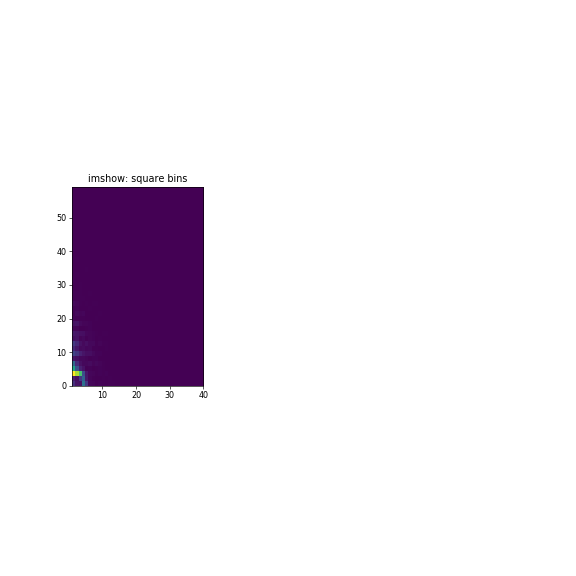

In [15]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(131, title='imshow: square bins')
plt.imshow(H, interpolation='nearest', origin='low',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])



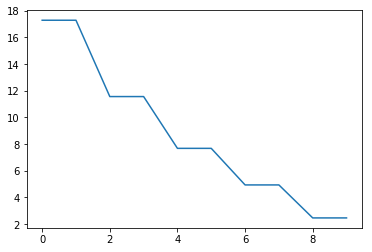

In [35]:
def length(i):
    non_0 = (np.abs(mouse_data[:, 0]) +  np.abs(mouse_data[:, 0])) > i
    return sum(non_0) / len(mouse_data) * 100
    
x = range(10)
y = [length(i) for i in x]
plt.plot(x, y)

In [64]:
hist

(array([2]), array([0, 0]))

In [65]:
mouse_data.shape

(19733, 2)